In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df=pd.read_csv('MSFT.csv')# this is the microsoft dataset downloaded from yahoo finance

In [4]:
dff= df[['Close']]  # Select the 'Date' and 'Close' columns

In [5]:
dff.head()

,Close
0,0.097222
1,0.100694
2,0.102431
3,0.099826
4,0.098090


In [6]:
# Define the split time
split_time = -30
x_train = dff['Close'][:split_time]



In [7]:
from sklearn.preprocessing import MinMaxScaler
x_train = np.array(x_train).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)



In [8]:
x_train

array([[1.61759331e-05],
       [2.42638997e-05],
       [2.83102125e-05],
       ...,
       [9.26551389e-01],
       [9.47097452e-01],
       [9.63124309e-01]])

In [12]:
# Parameters
window_size = 30
batch_size = 32
#shuffle_buffer_size = 1000

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
  #  dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [15]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 30, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 30, 128)           33792     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 128)           98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                4

In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
300/300 [==============================] - 43s 103ms/step - loss: 0.2877 - lr: 1.0000e-08
Epoch 2/100
 49/300 [===>..........................] - ETA: 29s - loss: 0.0856

KeyboardInterrupt: 

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [17]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 5e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
300/300 [==============================] - 42s 100ms/step - loss: 0.0665 - mae: 0.1931
Epoch 2/100
300/300 [==============================] - 31s 104ms/step - loss: 0.3012 - mae: 0.5771
Epoch 3/100
300/300 [==============================] - 29s 98ms/step - loss: 0.3669 - mae: 0.6066
Epoch 4/100
300/300 [==============================] - 29s 97ms/step - loss: 0.2123 - mae: 0.3915
Epoch 5/100
300/300 [==============================] - 30s 100ms/step - loss: 0.1206 - mae: 0.2968
Epoch 6/100
300/300 [==============================] - 33s 108ms/step - loss: 0.5022 - mae: 0.7482
Epoch 7/100
300/300 [==============================] - 29s 97ms/step - loss: 0.2072 - mae: 0.3643
Epoch 8/100
300/300 [==============================] - 31s 104ms/step - loss: 0.0731 - mae: 0.2083
Epoch 9/100
300/300 [==============================] - 29s 98ms/step - loss: 0.1012 - mae: 0.2582
Epoch 10/100
300/300 [==============================] - 29s 98ms/step - loss: 0.1912 - mae: 0.3557
Epoch 11/100
3

In [18]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [19]:
def iterative_forecast(model, series, window_size, batch_size, num_predictions):
    predictions = []
    input_series = series
    for _ in range(num_predictions):
        forecast = model_forecast(model, input_series, window_size, batch_size)
        next_prediction = forecast[-1]
        predictions.append(next_prediction)
        # Update the input series by appending the latest prediction
        input_series = np.append(input_series, next_prediction)
        input_series = input_series[-(window_size + 1):]
    return np.array(predictions)

In [20]:
# Get the validation data (last month)
x_valid = dff['Close'][split_time:-1]

# Prepare the series for forecasting
x_train_1 = dff['Close'][split_time-window_size:-30]
x_train_1 = np.array(x_train_1).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_1 = scaler.fit_transform(x_train_1)
x_train_1 = x_train_1.reshape(-1)
forecast_series = x_train_1

In [21]:

num_predictions = 30
predictions = iterative_forecast(model, forecast_series, window_size, batch_size, num_predictions)

# Denormalize the predictions
predictions = predictions.reshape(-1, 1)
denormalized_predictions = scaler.inverse_transform(predictions)


# Print or return results
print("Predictions:", denormalized_predictions)
print("Actual values:", x_valid)

1/1 [==============================] - 0s 44ms/step
Predictions: [[411.61447]
 [413.77606]
 [416.00034]
 [418.2136 ]
 [420.31516]
 [422.43317]
 [424.3465 ]
 [426.12042]
 [427.67975]
 [429.38806]
 [431.03854]
 [432.7612 ]
 [434.41083]
 [436.27994]
 [438.0665 ]
 [439.6497 ]
 [441.28754]
 [442.89822]
 [444.33588]
 [445.62335]
 [446.89926]
 [448.30692]
 [449.7588 ]
 [450.8427 ]
 [452.0143 ]
 [453.0108 ]
 [453.51492]
 [453.9514 ]
 [454.23257]
 [454.5203 ]]
Actual values: 9614    409.339996
9615    410.540009
9616    412.320007
9617    414.739990
9618    413.720001
9619    416.559998
9620    423.079987
9621    420.989990
9622    420.209991
9623    425.339996
9624    429.040009
9625    430.519989
9626    427.000000
9627    430.160004
9628    430.320007
9629    429.170013
9630    414.670013
9631    415.130005
9632    413.519989
9633    416.070007
9634    424.010010
9635    424.519989
9636    423.850006
9637    427.869995
9638    432.679993
9639    441.059998
9640    441.579987
9641    442.5700

In [24]:
results=denormalized_predictions
results_df = pd.DataFrame(results, columns=['Predictions'])
print(results_df)
print('test')
x_valid.reset_index(drop=True,inplace=True)
print(x_valid)

    Predictions
0    411.614471
1    413.776062
2    416.000336
3    418.213593
4    420.315155
5    422.433167
6    424.346497
7    426.120422
8    427.679749
9    429.388062
10   431.038544
11   432.761200
12   434.410828
13   436.279938
14   438.066498
15   439.649689
16   441.287537
17   442.898224
18   444.335876
19   445.623352
20   446.899261
21   448.306915
22   449.758789
23   450.842712
24   452.014313
25   453.010803
26   453.514923
27   453.951385
28   454.232574
29   454.520294
test
0     409.339996
1     410.540009
2     412.320007
3     414.739990
4     413.720001
5     416.559998
6     423.079987
7     420.989990
8     420.209991
9     425.339996
10    429.040009
11    430.519989
12    427.000000
13    430.160004
14    430.320007
15    429.170013
16    414.670013
17    415.130005
18    413.519989
19    416.070007
20    424.010010
21    424.519989
22    423.850006
23    427.869995
24    432.679993
25    441.059998
26    441.579987
27    442.570007
28    448.369995
Name: 

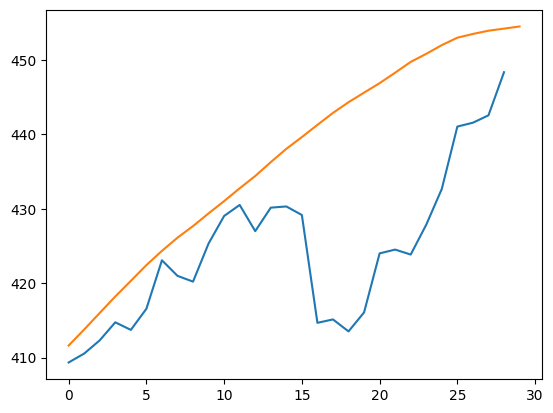

In [25]:

#results.reset_index()

plt.plot((x_valid))
plt.plot(results_df)
plt.show()

In [26]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results_df).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results_df).numpy())


[ 266.35178  215.54886  173.02806  140.53929  118.75795  105.74323
  101.69953  104.49136  112.14308  126.10805  145.14389  170.8229
  200.9763   241.71857  287.19247  332.8249   385.30832  442.15372
  497.27478  550.14636  605.8137   671.0065   742.3989   798.44684
  861.671    917.606    946.6597   972.22473  988.89667 1006.11957]
[13.063041  11.321545  10.102952   9.372677   8.72772    8.316006
  8.130913   8.35628    8.6720085  9.228096  10.113873  11.24811
 12.442668  13.796162  15.089877  16.236326  17.438046  18.829037
 20.16754   21.366224  22.55414   23.864714  25.312239  26.39616
 27.567762  28.56425   29.068373  29.504835  29.786024  30.073744 ]
